In [25]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [26]:
import numpy as np
import pandas as pd

In [27]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [28]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
        filtered_cv_results['momentum'] = pd.Categorical(filtered_cv_results['momentum'], 
                                                         ['none', 'standard', 'nesterov'])
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'n_iter', 
                         'train_r2', 'val_r2']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_n_iter', 
                                                              'mean_train_r2', 'mean_test_r2']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Epsilon-insensitive loss

### Primal formulation

In [29]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [30]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

In [60]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


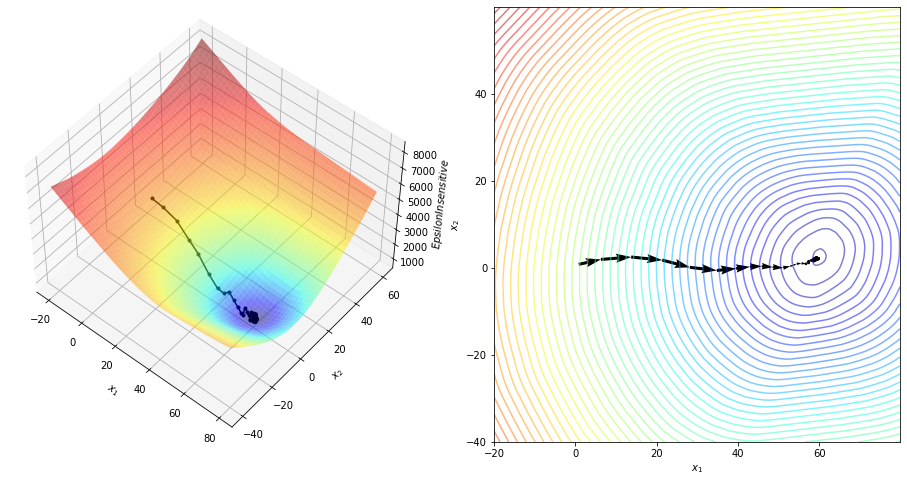

In [61]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              learning_rate=0.001, momentum=0.4, batch_size=20, early_stopping=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

eps_ins_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
eps_ins_loss_opt = plot_trajectory_optimization(eps_ins_loss, grid.best_estimator_.optimizer, color='k')
eps_ins_loss_opt.savefig('./tex/img/svr_eps_loss.png')

In [33]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
custom_primal_svr_eps_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svr_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
custom_primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver C   momentum epsilon                                                     
sgd    1   none     0.1      0.249611     760  0.149989  0.120937          66   
                    0.2      0.192403     606  0.149194  0.119413          64   
                    0.3      0.234755     668  0.141576  0.117340          63   
           standard 0.1      0.130968     421  0.152636  0.122085          66   
                    0.2      0.130517     430  0.145441  0.120561          65   
                    0.3      0.125757     409  0.150706  0.117829          63   
           nesterov 0.1      0.147389     469  0.151884  0.121175          65   
                    0.2      0.134867     428  0.151622  0.120448          64   
                    0.3      0.129361     436  0.145539  0.119799          64   
       10  none     0.1      0.058660     189  0.191182  0.121631          66   
                    0.2      0.047785     165  0.188020  0.136868          66   
                    0.3      0.046195     164  0.189523  0.135748          66   
           standard 0.1      0.040889     104  0.190812  0.134656          67   
                    0.2      0.033636     121  0.192966  0.121285          66   
                    0.3      0.029771     106  0.191772  0.133596          66   
           nesterov 0.1      0.031577     101  0.190989  0.132549          66   
                    0.2      0.033739     120  0.193509  0.122054          66   
                    0.3      0.035971     121  0.194362  0.123655          66   
       100 none     0.1      0.021250      73  0.198290  0.101637          67   
                    0.2      0.021624      76  0.198214  0.100616          67   
                    0.3      0.022537      76  0.198202  0.100586          66   
           standard 0.1      0.015694      52  0.198881  0.095927          67   
                    0.2      0.016488      52  0.198874  0.095903          66   
                    0.3      0.015401      52  0.198871  0.095973          66   
           nesterov 0.1      0.016523      54  0.198800  0.095754          67   
                    0.2      0.014956      54  0.198821  0.096050          66   
                    0.3      0.013285      56  0.198789  0.095604          66   

                             val_n_sv  
solver C   momentum epsilon            
sgd    1   none     0.1            32  
                    0.2            32  
                    0.3            32  
           standard 0.1            33  
                    0.2            32  
                    0.3            32  
           nesterov 0.1            33  
                    0.2            32  
                    0.3            32  
       10  none     0.1            33  
                    0.2            33  
                    0.3            32  
           standard 0.1            33  
                    0.2            33  
                    0.3            32  
           nesterov 0.1            33  
                    0.2            33  
                    0.3            33  
       100 none     0.1            33  
                    0.2            32  
                    0.3            32  
           standard 0.1            33  
                    0.2            33  
                    0.3            32  
           nesterov 0.1            33  
                    0.2            32  
                    0.3            32

In [34]:
grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [35]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
liblinear 1   -        0.1      0.000820      28  0.182188  0.124330   
                       0.2      0.000717      25  0.181681  0.122085   
                       0.3      0.000726      20  0.181938  0.119907   
          10  -        0.1      0.000668     130  0.189626  0.129734   
                       0.2      0.000839      93  0.190396  0.128257   
                       0.3      0.000529     118  0.191208  0.126846   
          100 -        0.1      0.001135     848  0.189731  0.131643   
                       0.2      0.001250     936  0.190433  0.131236   
                       0.3      0.001316    1000  0.191787  0.123712   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
liblinear 1   -        0.1              65        33  
                       0.2              65        32  
                       0.3              64        32  
          10  -        0.1              65        33  
                       0.2              65        33  
                       0.3              63        33  
          100 -        0.1              65        33  
                       0.2              64        33  
                       0.3              63        33

In [36]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', 
                                   caption='SVR Primal formulation results with Epsilon-insensitive loss', 
                                   label='primal_svr_eps_cv_results', position='H')
primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
sgd       1   none     0.1      0.249611     760  0.149989  0.120937   
                       0.2      0.192403     606  0.149194  0.119413   
                       0.3      0.234755     668  0.141576  0.117340   
              standard 0.1      0.130968     421  0.152636  0.122085   
                       0.2      0.130517     430  0.145441  0.120561   
                       0.3      0.125757     409  0.150706  0.117829   
              nesterov 0.1      0.147389     469  0.151884  0.121175   
                       0.2      0.134867     428  0.151622  0.120448   
                       0.3      0.129361     436  0.145539  0.119799   
          10  none     0.1      0.058660     189  0.191182  0.121631   
                       0.2      0.047785     165  0.188020  0.136868   
                       0.3      0.046195     164  0.189523  0.135748   
              standard 0.1      0.040889     104  0.190812  0.134656   
                       0.2      0.033636     121  0.192966  0.121285   
                       0.3      0.029771     106  0.191772  0.133596   
              nesterov 0.1      0.031577     101  0.190989  0.132549   
                       0.2      0.033739     120  0.193509  0.122054   
                       0.3      0.035971     121  0.194362  0.123655   
          100 none     0.1      0.021250      73  0.198290  0.101637   
                       0.2      0.021624      76  0.198214  0.100616   
                       0.3      0.022537      76  0.198202  0.100586   
              standard 0.1      0.015694      52  0.198881  0.095927   
                       0.2      0.016488      52  0.198874  0.095903   
                       0.3      0.015401      52  0.198871  0.095973   
              nesterov 0.1      0.016523      54  0.198800  0.095754   
                       0.2      0.014956      54  0.198821  0.096050   
                       0.3      0.013285      56  0.198789  0.095604   
liblinear 1   -        0.1      0.000820      28  0.182188  0.124330   
                       0.2      0.000717      25  0.181681  0.122085   
                       0.3      0.000726      20  0.181938  0.119907   
          10  -        0.1      0.000668     130  0.189626  0.129734   
                       0.2      0.000839      93  0.190396  0.128257   
                       0.3      0.000529     118  0.191208  0.126846   
          100 -        0.1      0.001135     848  0.189731  0.131643   
                       0.2      0.001250     936  0.190433  0.131236   
                       0.3      0.001316    1000  0.191787  0.123712   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
sgd       1   none     0.1              66        32  
                       0.2              64        32  
                       0.3              63        32  
              standard 0.1              66        33  
                       0.2              65        32  
                       0.3              63        32  
              nesterov 0.1              65        33  
                       0.2              64        32  
                       0.3              64        32  
          10  none     0.1              66        33  
                       0.2              66        33  
                       0.3              66        32  
              standard 0.1              67        33  
                       0.2              66        33  
                       0.3              66        32  
              nesterov 0.1              66        33  
                       0.2              66        33  
                       0.3              66        33  
          100 none     0.1              67        33  
                       0.2              67        32  
                       0.3              66        32  
              standard 0.1    

### Dual formulations

In [37]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_nonlinearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [38]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [39]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

In [40]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
     pcost       dcost       gap    pres   dres
 0: -1.3513e+04 -3.1249e+04  8e+04  1e+00  2e-15
 1: -6.9010e+03 -1.8254e+04  1e+04  4e-14  1e-15
 2: -8.6254e+03 -1.0278e+04  2e+03  1e-13  8e-16
 3: -9.2594e+03 -9.6259e+03  4e+02  2e-13  9e-16
 4: -9.3902e+03 -9.5025e+03  1e+02  1e-13  9e-16
 5: -9.4264e+03 -9.4664e+03  4e+01  2e-14  8e-16
 6: -9.4398e+03 -9.4521e+03  1e+01  7e-14  7e-16
 7: -9.4455e+03 -9.4465e+03  1e+00  1e-13  8e-16
 8: -9.4460e+03 -9.4460e+03  1e-02  7e-15  7e-16
 9: -9.4460e+03 -9.4460e+03  1e-04  9e-14  8e-16
Optimal solution found.


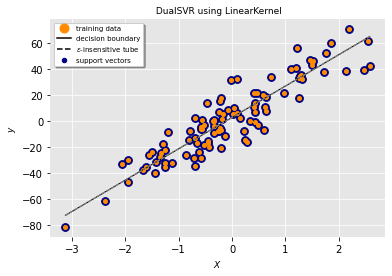

In [41]:
grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [42]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
cvxopt 1   0.1      0.021911       9  0.815872  0.805162          67        67
           0.2      0.018971      10  0.816274  0.805607          66        66
           0.3      0.012157       9  0.816837  0.806148          67        67
       10  0.1      0.016795       8  0.839164  0.824329          67        67
           0.2      0.013448       8  0.839203  0.824285          67        67
           0.3      0.013504       8  0.839237  0.824234          67        67
       100 0.1      0.012519       8  0.838233  0.821232          67        67
           0.2      0.014582       8  0.838473  0.821675          67        67
           0.3      0.010127       8  0.838686  0.822088          67        67
smo    1   0.1      0.018286      13  0.815865  0.804998          66        66
           0.2      0.016650      13  0.816266  0.805431          66        66
           0.3      0.015873      12  0.816829  0.806018          66        66
       10  0.1      0.039658      30  0.839160  0.824200          67        67
           0.2      0.041816      30  0.839199  0.824149          67        67
           0.3      0.037710      35  0.839234  0.824092          67        67
       100 0.1      0.161679     128  0.838229  0.820990          66        66
           0.2      0.206949     185  0.838469  0.821431          66        66
           0.3      0.231624     136  0.838683  0.821843          66        66

In [43]:
grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LibSVM]

In [44]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
libsvm 1   0.1      0.003243      52  0.815113  0.803346          66        66
           0.2      0.005966      52  0.815554  0.803517          66        66
           0.3      0.003237      57  0.816092  0.803425          66        66
       10  0.1      0.003931     111  0.837101  0.825608          67        67
           0.2      0.001921     114  0.837315  0.825348          67        67
           0.3      0.001678     163  0.837508  0.825064          67        67
       100 0.1      0.002190    1081  0.836676  0.824330          66        66
           0.2      0.001872     762  0.836958  0.824744          66        66
           0.3      0.001949    1433  0.837205  0.825121          66        66

In [45]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', 
                                    caption='Linear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                    label='linear_dual_svr_cv_results', position='H')
linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
smo    10  0.2      0.041816      30  0.839199  0.824149          67        67
       100 0.3      0.231624     136  0.838683  0.821843          66        66
           0.1      0.161679     128  0.838229  0.820990          66        66
       10  0.3      0.037710      35  0.839234  0.824092          67        67
           0.1      0.039658      30  0.839160  0.824200          67        67
       1   0.3      0.015873      12  0.816829  0.806018          66        66
           0.2      0.016650      13  0.816266  0.805431          66        66
           0.1      0.018286      13  0.815865  0.804998          66        66
       100 0.2      0.206949     185  0.838469  0.821431          66        66
libsvm 1   0.3      0.003237      57  0.816092  0.803425          66        66
       10  0.1      0.003931     111  0.837101  0.825608          67        67
           0.2      0.001921     114  0.837315  0.825348          67        67
           0.3      0.001678     163  0.837508  0.825064          67        67
       1   0.1      0.003243      52  0.815113  0.803346          66        66
       100 0.1      0.002190    1081  0.836676  0.824330          66        66
           0.2      0.001872     762  0.836958  0.824744          66        66
       1   0.2      0.005966      52  0.815554  0.803517          66        66
       100 0.3      0.001949    1433  0.837205  0.825121          66        66
cvxopt 1   0.2      0.018971      10  0.816274  0.805607          66        66
       100 0.3      0.010127       8  0.838686  0.822088          67        67
           0.2      0.014582       8  0.838473  0.821675          67        67
           0.1      0.012519       8  0.838233  0.821232          67        67
       10  0.3      0.013504       8  0.839237  0.824234          67        67
           0.2      0.013448       8  0.839203  0.824285          67        67
           0.1      0.016795       8  0.839164  0.824329          67        67
       1   0.3      0.012157       9  0.816837  0.806148          67        67
           0.1      0.021911       9  0.815872  0.805162          67        67

##### Nonlinear

In [ ]:
X, y = generate_nonlinearly_regression_data()

Fitting 3 folds for each of 18 candidates, totalling 54 fits
     pcost       dcost       gap    pres   dres
 0:  7.1805e+00 -2.2450e+02  2e+02  2e-15  5e-12
 1:  5.7490e+00 -1.5728e+01  2e+01  1e-14  7e-12
 2: -4.8784e-01 -3.7633e+00  3e+00  3e-15  4e-12
 3: -2.0433e+00 -2.7798e+00  7e-01  6e-15  4e-12
 4: -2.3179e+00 -2.5674e+00  2e-01  5e-15  3e-12
 5: -2.4431e+00 -2.4758e+00  3e-02  1e-15  3e-12
 6: -2.4594e+00 -2.4634e+00  4e-03  3e-15  3e-12
 7: -2.4614e+00 -2.4617e+00  3e-04  4e-16  3e-12
 8: -2.4616e+00 -2.4616e+00  5e-06  2e-15  3e-12
 9: -2.4616e+00 -2.4616e+00  5e-08  9e-16  3e-12
Optimal solution found.


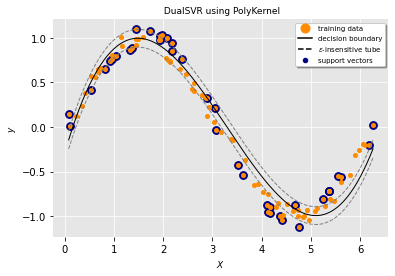

In [31]:
grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

In [32]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                              
cvxopt poly   1   0.1         0.015057       10  0.848547  -5.090164   
                  0.2         0.017265       10 -3.609617  -8.632746   
                  0.3         0.011037       10 -0.786399  -8.517434   
              10  0.1         0.010415       10  0.968145  -5.331473   
                  0.2         0.022692       10 -3.609013  -8.638973   
                  0.3         0.011880       10 -0.780783  -8.483884   
              100 0.1         0.012144       10  0.945501  -5.188429   
                  0.2         0.014013       10 -3.608986  -8.638995   
                  0.3         0.012482       10 -0.780887  -8.484199   
smo    poly   1   0.1        80.259683   175472  0.850381  -6.479953   
                  0.2         4.845339     6682 -5.669765 -15.026022   
                  0.3         0.531903      909 -2.663418 -16.100682   
              10  0.1       660.696393  1352666  0.958635  -6.309580   
                  0.2         3.283288     5413 -5.659396 -15.048805   
                  0.3         4.703530     7008 -2.652290 -16.086707   
              100 0.1      3838.989156  9325434  0.956258  -6.351469   
                  0.2         3.581371     5413 -5.659396 -15.048805   
                  0.3         2.518382     7008 -2.652290 -16.086707   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
cvxopt poly   1   0.1              23        23  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              25        25  
                  0.2               4         4  
                  0.3               4         4  
              100 0.1              27        27  
                  0.2               4         4  
                  0.3               4         4  
smo    poly   1   0.1              23        23  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              23        23  
                  0.2               4         4  
                  0.3               4         4  
              100 0.1              23        23  
                  0.2               4         4  
                  0.3               4         4

Fitting 3 folds for each of 18 candidates, totalling 54 fits


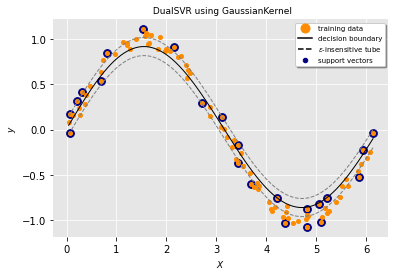

In [33]:
grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [34]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver kernel C   epsilon                                                     
cvxopt rbf    1   0.1      0.014662      10  0.979933  0.327020          14   
                  0.2      0.021198      10  0.961792 -0.943080           6   
                  0.3      0.017357       9  0.890164 -1.687411           5   
              10  0.1      0.014854      10  0.977704  0.640986          14   
                  0.2      0.016555      10  0.952051 -0.963789           6   
                  0.3      0.014812      10  0.882145 -1.696148           4   
              100 0.1      0.015500      10  0.974118  0.715636          15   
                  0.2      0.018510      10  0.965122 -0.935738           7   
                  0.3      0.018584      10  0.882145 -1.696145           4   
smo    rbf    1   0.1      0.035963      30  0.979269  0.337883          14   
                  0.2      0.014002      14  0.953442 -0.706423           6   
                  0.3      0.009471       9  0.880480 -1.956576           5   
              10  0.1      0.294246     198  0.979879  0.614804          14   
                  0.2      0.018293      20  0.943679 -0.729439           5   
                  0.3      0.010107      11  0.872418 -1.965274           4   
              100 0.1      0.869753    1199  0.976323  0.735233          14   
                  0.2      0.019184      20  0.943679 -0.729439           5   
                  0.3      0.008680      11  0.872418 -1.965274           4   

                           val_n_sv  
solver kernel C   epsilon            
cvxopt rbf    1   0.1            14  
                  0.2             6  
                  0.3             5  
              10  0.1            14  
                  0.2             6  
                  0.3             4  
              100 0.1            15  
                  0.2             7  
                  0.3             4  
smo    rbf    1   0.1            14  
                  0.2             6  
                  0.3             5  
              10  0.1            14  
                  0.2             5  
                  0.3             4  
              100 0.1            14  
                  0.2             5  
                  0.3             4

In [35]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                              
cvxopt poly   1   0.1         0.015057       10  0.848547  -5.090164   
                  0.2         0.017265       10 -3.609617  -8.632746   
                  0.3         0.011037       10 -0.786399  -8.517434   
              10  0.1         0.010415       10  0.968145  -5.331473   
                  0.2         0.022692       10 -3.609013  -8.638973   
                  0.3         0.011880       10 -0.780783  -8.483884   
              100 0.1         0.012144       10  0.945501  -5.188429   
                  0.2         0.014013       10 -3.608986  -8.638995   
                  0.3         0.012482       10 -0.780887  -8.484199   
       rbf    1   0.1         0.014662       10  0.979933   0.327020   
                  0.2         0.021198       10  0.961792  -0.943080   
                  0.3         0.017357        9  0.890164  -1.687411   
              10  0.1         0.014854       10  0.977704   0.640986   
                  0.2         0.016555       10  0.952051  -0.963789   
                  0.3         0.014812       10  0.882145  -1.696148   
              100 0.1         0.015500       10  0.974118   0.715636   
                  0.2         0.018510       10  0.965122  -0.935738   
                  0.3         0.018584       10  0.882145  -1.696145   
smo    poly   1   0.1        80.259683   175472  0.850381  -6.479953   
                  0.2         4.845339     6682 -5.669765 -15.026022   
                  0.3         0.531903      909 -2.663418 -16.100682   
              10  0.1       660.696393  1352666  0.958635  -6.309580   
                  0.2         3.283288     5413 -5.659396 -15.048805   
                  0.3         4.703530     7008 -2.652290 -16.086707   
              100 0.1      3838.989156  9325434  0.956258  -6.351469   
                  0.2         3.581371     5413 -5.659396 -15.048805   
                  0.3         2.518382     7008 -2.652290 -16.086707   
       rbf    1   0.1         0.035963       30  0.979269   0.337883   
                  0.2         0.014002       14  0.953442  -0.706423   
                  0.3         0.009471        9  0.880480  -1.956576   
              10  0.1         0.294246      198  0.979879   0.614804   
                  0.2         0.018293       20  0.943679  -0.729439   
                  0.3         0.010107       11  0.872418  -1.965274   
              100 0.1         0.869753     1199  0.976323   0.735233   
                  0.2         0.019184       20  0.943679  -0.729439   
                  0.3         0.008680       11  0.872418  -1.965274   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
cvxopt poly   1   0.1              23        23  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              25        25  
                  0.2               4         4  
                  0.3               4         4  
              100 0.1              27        27  
                  0.2               4         4  
                  0.3               4         4  
       rbf    1   0.1              14        14  
                  0.2               6         6  
                  0.3               5         5  
              10  0.1              14        14  
                  0.2               6         6  
                  0.3               4         4  
              100 0.1              15        15  
                  0.2               7         7  
                  0.3               4         4  
smo    poly   1   0.1              23        23  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              23        23  
                  0.2               4         4  
                  0.3               4      

In [36]:
grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LibSVM]

In [37]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  train_n_sv  \
solver kernel C   epsilon                                                       
libsvm poly   1   0.1      0.065331   202636  0.981648 -29.427063          20   
                  0.2      0.008808     5634  0.971457 -44.854253           5   
                  0.3      0.012103     1133  0.921669 -67.995416           4   
              10  0.1      0.577278  2329808  0.981723 -28.867737          18   
                  0.2      0.012278     4967  0.972091 -44.851795           4   
                  0.3      0.001801      925  0.922233 -67.994190           3   
              100 0.1      1.439916  6416597  0.980670 -14.594558          24   
                  0.2      0.009960     4967  0.972091 -44.851795           4   
                  0.3      0.021700      925  0.922233 -67.994190           3   
       rbf    1   0.1      0.015557       71  0.986549  -2.969459          16   
                  0.2      0.018801       33  0.964555  -4.149278           5   
                  0.3      0.002971        8  0.912691  -4.815179           4   
              10  0.1      0.004562      474  0.987401  -2.477526          15   
                  0.2      0.011069       34  0.964563  -4.149231           5   
                  0.3      0.001300        8  0.913367  -4.813685           4   
              100 0.1      0.006711     2712  0.987693  -1.428809          13   
                  0.2      0.002964       34  0.964563  -4.149231           5   
                  0.3      0.002766        8  0.913367  -4.813685           4   

                           val_n_sv  
solver kernel C   epsilon            
libsvm poly   1   0.1            20  
                  0.2             5  
                  0.3             4  
              10  0.1            18  
                  0.2             4  
                  0.3             3  
              100 0.1            24  
                  0.2             4  
                  0.3             3  
       rbf    1   0.1            16  
                  0.2             5  
                  0.3             4  
              10  0.1            15  
                  0.2             5  
                  0.3             4  
              100 0.1            13  
                  0.2             5  
                  0.3             4

In [38]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.sort_values(['solver'], ascending=False, inplace=True)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', 
                                       caption='Nonlinear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                       label='nonlinear_dual_svr_cv_results', position='H')
nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                              
cvxopt poly   1   0.1         0.015057       10  0.848547  -5.090164   
                  0.2         0.017265       10 -3.609617  -8.632746   
                  0.3         0.011037       10 -0.786399  -8.517434   
              10  0.1         0.010415       10  0.968145  -5.331473   
                  0.2         0.022692       10 -3.609013  -8.638973   
                  0.3         0.011880       10 -0.780783  -8.483884   
              100 0.1         0.012144       10  0.945501  -5.188429   
                  0.2         0.014013       10 -3.608986  -8.638995   
                  0.3         0.012482       10 -0.780887  -8.484199   
       rbf    1   0.1         0.014662       10  0.979933   0.327020   
                  0.2         0.021198       10  0.961792  -0.943080   
                  0.3         0.017357        9  0.890164  -1.687411   
              10  0.1         0.014854       10  0.977704   0.640986   
                  0.2         0.016555       10  0.952051  -0.963789   
                  0.3         0.014812       10  0.882145  -1.696148   
              100 0.1         0.015500       10  0.974118   0.715636   
                  0.2         0.018510       10  0.965122  -0.935738   
                  0.3         0.018584       10  0.882145  -1.696145   
smo    poly   1   0.1        80.259683   175472  0.850381  -6.479953   
                  0.2         4.845339     6682 -5.669765 -15.026022   
                  0.3         0.531903      909 -2.663418 -16.100682   
              10  0.1       660.696393  1352666  0.958635  -6.309580   
                  0.2         3.283288     5413 -5.659396 -15.048805   
                  0.3         4.703530     7008 -2.652290 -16.086707   
              100 0.1      3838.989156  9325434  0.956258  -6.351469   
                  0.2         3.581371     5413 -5.659396 -15.048805   
                  0.3         2.518382     7008 -2.652290 -16.086707   
       rbf    1   0.1         0.035963       30  0.979269   0.337883   
                  0.2         0.014002       14  0.953442  -0.706423   
                  0.3         0.009471        9  0.880480  -1.956576   
              10  0.1         0.294246      198  0.979879   0.614804   
                  0.2         0.018293       20  0.943679  -0.729439   
                  0.3         0.010107       11  0.872418  -1.965274   
              100 0.1         0.869753     1199  0.976323   0.735233   
                  0.2         0.019184       20  0.943679  -0.729439   
                  0.3         0.008680       11  0.872418  -1.965274   
libsvm poly   1   0.1         0.065331   202636  0.981648 -29.427063   
                  0.2         0.008808     5634  0.971457 -44.854253   
                  0.3         0.012103     1133  0.921669 -67.995416   
              10  0.1         0.577278  2329808  0.981723 -28.867737   
                  0.2         0.012278     4967  0.972091 -44.851795   
                  0.3         0.001801      925  0.922233 -67.994190   
              100 0.1         1.439916  6416597  0.980670 -14.594558   
                  0.2         0.009960     4967  0.972091 -44.851795   
                  0.3         0.021700      925  0.922233 -67.994190   
       rbf    1   0.1         0.015557       71  0.986549  -2.969459   
                  0.2         0.018801       33  0.964555  -4.149278   
                  0.3         0.002971        8  0.912691  -4.815179   
              10  0.1         0.004562      474  0.987401  -2.477526   
                  0.2         0.011069       34  0.964563  -4.149231   
                  0.3         0.001300        8  0.913367  -4.813685   
              100 0.1         0.006711     2712  0.987693  -1.428809   
                  0.2         0.002964       34  0.964563  -4.149231   
                  0.3         0.002766        8  0.913367  -4.813685  

#### Lagrangian Dual

##### Linear

In [46]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

In [47]:
grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [48]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], ascending=[False, True], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', 
                                               caption='Linear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                               label='linear_lagrangian_dual_svr_cv_results', position='H')
linear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
dual C   epsilon                                                            
qp   1   0.1      0.082322      44  0.684957  0.676764          67        67
         0.2      0.087632      44  0.684957  0.676764          67        67
         0.3      0.083518      44  0.684957  0.676763          67        67
     10  0.1      0.823205     728  0.736303  0.730094          67        67
         0.2      0.840446     735  0.736303  0.730093          67        67
         0.3      0.794968     741  0.736303  0.730092          67        67
     100 0.1      0.870177     728  0.736303  0.730094          67        67
         0.2      0.520331     735  0.736303  0.730093          67        67
         0.3      0.570781     741  0.736303  0.730092          67        67
bcqp 1   0.1      0.050349      32  0.683134  0.674912          67        67
         0.2      0.051552      32  0.683134  0.674912          67        67
         0.3      0.053362      32  0.683134  0.674911          67        67
     10  0.1      0.242091     207  0.738281  0.732098          67        67
         0.2      0.229870     209  0.738281  0.732097          67        67
         0.3      0.245216     210  0.738281  0.732096          67        67
     100 0.1      0.243215     207  0.738281  0.732098          67        67
         0.2      0.113374     209  0.738281  0.732097          67        67
         0.3      0.186780     210  0.738281  0.732096          67        67

##### Nonlinear

In [49]:
X, y = generate_nonlinearly_regression_data()

In [50]:
grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [51]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', 
                                                  caption='Nonlinear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                                  label='nonlinear_lagrangian_dual_svr_cv_results', position='H')
nonlinear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2     val_r2  train_n_sv  \
dual kernel C   epsilon                                                      
qp   poly   1   0.1      0.013927       6  0.639582 -36.017167          66   
                0.2      0.453497     345  0.605891 -20.582313          66   
                0.3      0.437990     352  0.583454 -20.438316          66   
            10  0.1      0.009494       6  0.639582 -36.017167          66   
                0.2      0.403863     345  0.605891 -20.582313          66   
                0.3      0.425059     352  0.583454 -20.438316          66   
            100 0.1      0.009305       6  0.639582 -36.017167          66   
                0.2      0.442313     345  0.605891 -20.582313          66   
                0.3      0.384443     352  0.583454 -20.438316          66   
     rbf    1   0.1      0.257837     128  0.684133  -4.688319          67   
                0.2      0.376743     191  0.640105  -5.221665          67   
                0.3      0.403506     232  0.641703  -5.218774          67   
            10  0.1      0.115396      67  0.682317  -4.657718          67   
                0.2      0.126903      76  0.637857  -5.267631          67   
                0.3      0.179693     108  0.638812  -5.210237          67   
            100 0.1      0.114128      67  0.682317  -4.657718          67   
                0.2      0.136213      76  0.637857  -5.267631          67   
                0.3      0.205061     108  0.638812  -5.210237          67   
bcqp poly   1   0.1      0.012580       8  0.640796 -36.909689          67   
                0.2      0.409737     345  0.599211 -19.429431          66   
                0.3      0.418357     354  0.581901 -19.286390          66   
            10  0.1      0.012921       8  0.640796 -36.909689          67   
                0.2      0.399091     345  0.599211 -19.429431          66   
                0.3      0.449794     354  0.581901 -19.286390          66   
            100 0.1      0.011779       8  0.640796 -36.909689          67   
                0.2      0.385712     345  0.599211 -19.429431          66   
                0.3      0.274509     354  0.581901 -19.286390          66   
     rbf    1   0.1      0.245458     134  0.733531  -5.051724          67   
                0.2      0.373509     244  0.669836  -5.935346          67   
                0.3      0.467384     300  0.529430  -7.181043          67   
            10  0.1      0.201872     134  0.733531  -5.051724          67   
                0.2      0.381918     244  0.669836  -5.935346          67   
                0.3      0.446960     300  0.529430  -7.181043          67   
            100 0.1      0.230169     134  0.733531  -5.051724          67   
                0.2      0.409371     244  0.669836  -5.935346          67   
                0.3      0.363330     300  0.529430  -7.181043          67   

                         val_n_sv  
dual kernel C   epsilon            
qp   poly   1   0.1            66  
                0.2            66  
                0.3            66  
            10  0.1            66  
                0.2            66  
                0.3            66  
            100 0.1            66  
                0.2            66  
                0.3            66  
     rbf    1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
bcqp poly   1   0.1            67  
                0.2            66  
                0.3            66  
            10  0.1            67  
                0.2            66  
                0.3            66  
            100 0.1            67  
                0.2            66  
                0.3            66  
     rbf    1   

## Squared Epsilon-insensitive loss

### Primal formulation

In [52]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [53]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

In [54]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


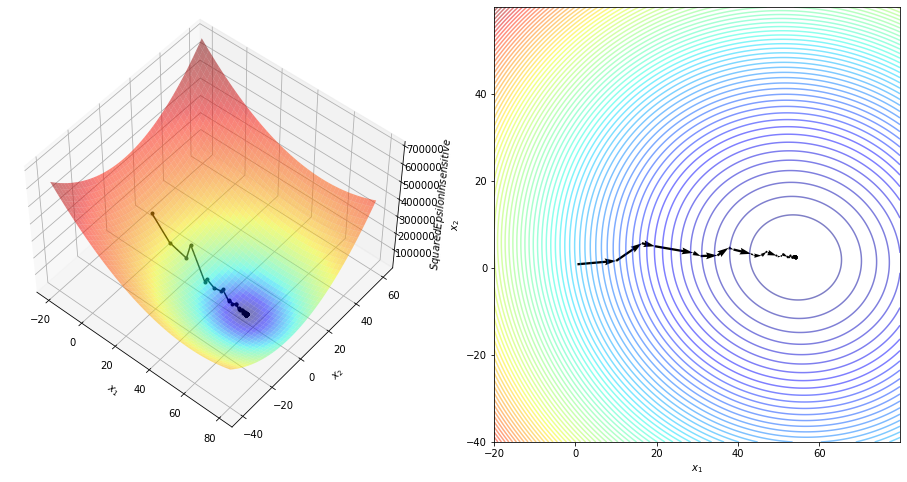

In [55]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              learning_rate=0.001, momentum=0.4, batch_size=20, early_stopping=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

squared_eps_ins_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
eps_ins_loss_opt = plot_trajectory_optimization(squared_eps_ins_loss, grid.best_estimator_.optimizer, color='k')
eps_ins_loss_opt.savefig('./tex/img/svr_squared_eps_loss.png')

In [56]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
custom_primal_svr_squared_eps_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
custom_primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver C   momentum epsilon                                                     
sgd    1   none     0.1      0.998142    3514  0.950025  0.949398          66   
                    0.2      1.061005    3506  0.950021  0.949390          65   
                    0.3      1.144199    3501  0.950013  0.949375          65   
           standard 0.1      0.897087    3181  0.950405  0.949700          66   
                    0.2      0.973385    3141  0.950400  0.949690          66   
                    0.3      1.045926    3161  0.950396  0.949674          65   
           nesterov 0.1      0.927794    3180  0.950404  0.949698          66   
                    0.2      0.966410    3128  0.950400  0.949687          66   
                    0.3      0.952549    3162  0.950396  0.949674          65   
       10  none     0.1      0.238493     748  0.953228  0.952327          66   
                    0.2      0.222435     764  0.953226  0.952325          65   
                    0.3      0.224572     766  0.953227  0.952330          65   
           standard 0.1      0.145276     466  0.953239  0.952335          66   
                    0.2      0.136965     476  0.953237  0.952334          65   
                    0.3      0.140296     476  0.953237  0.952332          65   
           nesterov 0.1      0.140689     433  0.953238  0.952340          66   
                    0.2      0.148832     480  0.953238  0.952333          65   
                    0.3      0.148917     481  0.953238  0.952339          65   
       100 none     0.1      0.045094     112  0.953245  0.952464          66   
                    0.2      0.033974     113  0.953245  0.952463          65   
                    0.3      0.032519     114  0.953246  0.952463          65   
           standard 0.1      0.022043      64  0.953353  0.952350          66   
                    0.2      0.022274      64  0.953354  0.952355          65   
                    0.3      0.018994      64  0.953353  0.952355          65   
           nesterov 0.1      0.027364      70  0.953342  0.952399          66   
                    0.2      0.022963      70  0.953342  0.952399          65   
                    0.3      0.018148      70  0.953344  0.952403          65   

                             val_n_sv  
solver C   momentum epsilon            
sgd    1   none     0.1            33  
                    0.2            33  
                    0.3            33  
           standard 0.1            33  
                    0.2            33  
                    0.3            33  
           nesterov 0.1            33  
                    0.2            33  
                    0.3            33  
       10  none     0.1            33  
                    0.2            32  
                    0.3            32  
           standard 0.1            33  
                    0.2            32  
                    0.3            32  
           nesterov 0.1            33  
                    0.2            32  
                    0.3            32  
       100 none     0.1            33  
                    0.2            32  
                    0.3            32  
           standard 0.1            33  
                    0.2            32  
                    0.3            32  
           nesterov 0.1            33  
                    0.2            32  
                    0.3            32

In [57]:
grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [58]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
liblinear 1   -        0.1      0.000835      83  0.953364  0.951900   
                       0.2      0.000868      81  0.953361  0.951889   
                       0.3      0.000795      78  0.953358  0.951894   
          10  -        0.1      0.003187     774  0.953463  0.952028   
                       0.2      0.002703     784  0.953463  0.952038   
                       0.3      0.002828     761  0.953462  0.952040   
          100 -        0.1      0.003428    1000  0.953068  0.950829   
                       0.2      0.003628    1000  0.953315  0.952273   
                       0.3      0.003517    1000  0.953432  0.951692   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
liblinear 1   -        0.1              66        33  
                       0.2              66        33  
                       0.3              65        33  
          10  -        0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
          100 -        0.1              66        33  
                       0.2              65        33  
                       0.3              65        32

In [59]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', 
                                           caption='SVR Primal formulation results with Squared Epsilon-insensitive loss', 
                                           label='primal_svr_squared_eps_cv_results', position='H')
primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
sgd       1   none     0.1      0.998142    3514  0.950025  0.949398   
                       0.2      1.061005    3506  0.950021  0.949390   
                       0.3      1.144199    3501  0.950013  0.949375   
              standard 0.1      0.897087    3181  0.950405  0.949700   
                       0.2      0.973385    3141  0.950400  0.949690   
                       0.3      1.045926    3161  0.950396  0.949674   
              nesterov 0.1      0.927794    3180  0.950404  0.949698   
                       0.2      0.966410    3128  0.950400  0.949687   
                       0.3      0.952549    3162  0.950396  0.949674   
          10  none     0.1      0.238493     748  0.953228  0.952327   
                       0.2      0.222435     764  0.953226  0.952325   
                       0.3      0.224572     766  0.953227  0.952330   
              standard 0.1      0.145276     466  0.953239  0.952335   
                       0.2      0.136965     476  0.953237  0.952334   
                       0.3      0.140296     476  0.953237  0.952332   
              nesterov 0.1      0.140689     433  0.953238  0.952340   
                       0.2      0.148832     480  0.953238  0.952333   
                       0.3      0.148917     481  0.953238  0.952339   
          100 none     0.1      0.045094     112  0.953245  0.952464   
                       0.2      0.033974     113  0.953245  0.952463   
                       0.3      0.032519     114  0.953246  0.952463   
              standard 0.1      0.022043      64  0.953353  0.952350   
                       0.2      0.022274      64  0.953354  0.952355   
                       0.3      0.018994      64  0.953353  0.952355   
              nesterov 0.1      0.027364      70  0.953342  0.952399   
                       0.2      0.022963      70  0.953342  0.952399   
                       0.3      0.018148      70  0.953344  0.952403   
liblinear 1   -        0.1      0.000835      83  0.953364  0.951900   
                       0.2      0.000868      81  0.953361  0.951889   
                       0.3      0.000795      78  0.953358  0.951894   
          10  -        0.1      0.003187     774  0.953463  0.952028   
                       0.2      0.002703     784  0.953463  0.952038   
                       0.3      0.002828     761  0.953462  0.952040   
          100 -        0.1      0.003428    1000  0.953068  0.950829   
                       0.2      0.003628    1000  0.953315  0.952273   
                       0.3      0.003517    1000  0.953432  0.951692   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
sgd       1   none     0.1              66        33  
                       0.2              65        33  
                       0.3              65        33  
              standard 0.1              66        33  
                       0.2              66        33  
                       0.3              65        33  
              nesterov 0.1              66        33  
                       0.2              66        33  
                       0.3              65        33  
          10  none     0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
              standard 0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
              nesterov 0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
          100 none     0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
              standard 0.1    